In [1]:
# --- Cell: read .txt files from folders F, N, O, S, Z --------------------
from pathlib import Path
import numpy as np  # to load numeric .txt files

DATA_ROOT = Path("DATASET-2")  # root where F/, N/, O/, S/, Z/ folders are located

# Each key will be a folder name.
# 👉 “Positive” classes are F and N; the rest are considered “negative”.
labels = ["F", "N", "O", "S", "Z"]
dataset = {lbl: [] for lbl in labels}

for lbl in labels:
    folder = DATA_ROOT / lbl  # ./F, ./N, ...
    txt_files = sorted(folder.glob(f"{lbl}[0-9][0-9][0-9].txt")) \
          + sorted(folder.glob(f"{lbl}[0-9][0-9][0-9].TXT"))  # F000.txt … F100.txt

    if not txt_files:
        print(f"⚠️  No .txt files found in {folder}")
        continue

    print(f"📂 Reading {len(txt_files)} files from “{lbl}”…")
    for f in txt_files:
        try:
            # Each .txt contains only numbers (a single column) ──> 1‑D np.ndarray
            data = np.loadtxt(f, dtype=float)  # shape: (n_samples,)
            dataset[lbl].append({"file": f.name, "data": data})
        except Exception as e:
            print(f"  ⛔️ Error reading {f.name}: {e}")

print("\n✔️  Finished reading all files.")

📂 Reading 100 files from “F”…
📂 Reading 100 files from “N”…
📂 Reading 100 files from “O”…
📂 Reading 100 files from “S”…
📂 Reading 100 files from “Z”…

✔️  Finished reading all files.


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import skew, kurtosis, entropy

# --- Funciones para métricas ---
def hjorth_parameters(signal):
    """Calcula Activity, Mobility y Complexity."""
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(first_deriv) / activity) if activity > 0 else 0
    complexity = (np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility) if mobility > 0 else 0

    return activity, mobility, complexity

def signal_energy(signal):
    return np.sum(signal ** 2)

def signal_entropy(signal, bins=30):
    hist, _ = np.histogram(signal, bins=bins, density=True)
    return entropy(hist + 1e-12)  # evitar log(0)

def signal_rms(signal):
    return np.sqrt(np.mean(signal ** 2))

# --- Rutas y dataset ---
DATA_ROOT = Path("DATASET-2")
labels = ["F", "N", "O", "S", "Z"]

# --- DataFrame para resultados ---
metrics_list = []

for lbl in labels:
    folder = DATA_ROOT / lbl
    txt_files = sorted(folder.glob("*.txt")) + sorted(folder.glob("*.TXT"))

    print(f"📂 Procesando {len(txt_files)} archivos de '{lbl}'...")
    for f in txt_files:
        try:
            data = np.loadtxt(f, dtype=float)

            # --- Métricas básicas ---
            mean_val = np.mean(data)
            std_val = np.std(data)
            var_val = np.var(data)
            max_val = np.max(data)
            min_val = np.min(data)
            median_val = np.median(data)
            rms_val = signal_rms(data)
            skew_val = skew(data)
            kurtosis_val = kurtosis(data)

            # --- Hjorth ---
            activity, mobility, complexity = hjorth_parameters(data)

            # --- Energía y Entropía ---
            energy_val = signal_energy(data)
            entropy_val = signal_entropy(data)

            # --- Guardar en lista ---
            metrics_list.append({
                "file": f.name,
                "label": lbl,
                "mean": mean_val,
                "std": std_val,
                "var": var_val,
                "max": max_val,
                "min": min_val,
                "median": median_val,
                "rms": rms_val,
                "skew": skew_val,
                "kurtosis": kurtosis_val,
                "activity": activity,
                "mobility": mobility,
                "complexity": complexity,
                "energy": energy_val,
                "entropy": entropy_val
            })

        except Exception as e:
            print(f"⛔ Error leyendo {f.name}: {e}")

# --- Crear DataFrame final ---
df_metrics = pd.DataFrame(metrics_list)
print("\n✅ Métricas calculadas con éxito.")
print(df_metrics.head())

# --- Guardar en CSV opcional ---
df_metrics.to_csv("metrics_dataset.csv", index=False)
print("📁 Archivo 'metrics_dataset.csv' guardado.")


📂 Procesando 100 archivos de 'F'...
📂 Procesando 100 archivos de 'N'...
📂 Procesando 100 archivos de 'O'...
📂 Procesando 100 archivos de 'S'...
📂 Procesando 100 archivos de 'Z'...

✅ Métricas calculadas con éxito.
       file label       mean         std           var    max    min  median  \
0  F001.txt     F  28.570417   28.625071    819.394663  123.0  -64.0    29.0   
1  F002.txt     F  31.778374  133.475722  17815.768309  893.0 -269.0    26.0   
2  F003.txt     F -25.015865   71.958091   5177.966797  181.0 -253.0   -27.0   
3  F004.txt     F -35.252136   37.801572   1428.958883   76.0 -177.0   -35.0   
4  F005.txt     F -15.550647   84.285276   7104.007747  295.0 -401.0   -25.0   

          rms      skew  kurtosis      activity  mobility  complexity  \
0   40.443336  0.083647 -0.180720    819.394663  0.217637    4.740927   
1  137.206536  2.184076  8.934308  17815.768309  0.143801    3.557419   
2   76.182415  0.049846 -0.254974   5177.966797  0.214105    2.907144   
3   51.688219

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = []
y = []

positive_classes = ["F", "N"]  # 1
negative_classes = ["O", "S", "Z"]  # 0

for label, files in dataset.items():
    for d in files:
        X.append(d["data"])
        y.append(1 if label in positive_classes else 0)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Etiquetas únicas (0=negativo, 1=positivo):", np.unique(y, return_counts=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_raw = PCA(n_components=100)
X_pca_raw = pca_raw.fit_transform(X_scaled)

varianza_total = np.sum(pca_raw.explained_variance_ratio_) * 100
print("PCA:", X_pca_raw.shape)
print(f"Varianza acumulada explicada: {varianza_total:.2f}%")

pca_columns = [f"PC{i+1}" for i in range(X_pca_raw.shape[1])]
df_pca_raw = pd.DataFrame(X_pca_raw, columns=pca_columns)
df_pca_raw["Label"] = y  # Ya es binario

print("\n Primeras filas del PCA con Label binario:")
print(df_pca_raw.head())

X shape: (500, 4097) | y shape: (500,)
Etiquetas únicas (0=negativo, 1=positivo): (array([0, 1]), array([300, 200]))
PCA: (500, 100)
Varianza acumulada explicada: 93.86%

 Primeras filas del PCA con Label binario:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.910810 -0.432789  1.557870  1.238957  6.244845  5.608685 -0.011796   
1  0.669241 -2.770761  2.628015  1.059362  5.188711  8.703730 -2.145227   
2  1.796252  2.188240 -0.747876 -1.133820 -3.750040 -2.946909 -1.082376   
3  2.203993  2.113146 -0.424998 -1.584056 -5.539428 -5.599065 -0.269519   
4  0.535932  1.589788 -0.389448 -1.399532 -2.005868 -2.518123  0.547491   

        PC8       PC9      PC10  ...      PC92      PC93      PC94      PC95  \
0  4.849851  6.243333  1.448628  ... -0.184560 -0.689099  0.971764  1.003878   
1  8.147524  7.337089  0.293559  ... -5.548964  0.342728 -1.218282  0.927793   
2 -1.652842 -2.302908 -1.303553  ... -1.019823  1.750772  1.864252 -0.284612   
3 -3.230361 -5.

In [8]:
output_file = "dataset2_PCA_100.csv"
df_pca_raw.to_csv(output_file, index=False)

print(f"✅ Archivo guardado correctamente como '{output_file}'")

✅ Archivo guardado correctamente como 'dataset2_PCA_100.csv'


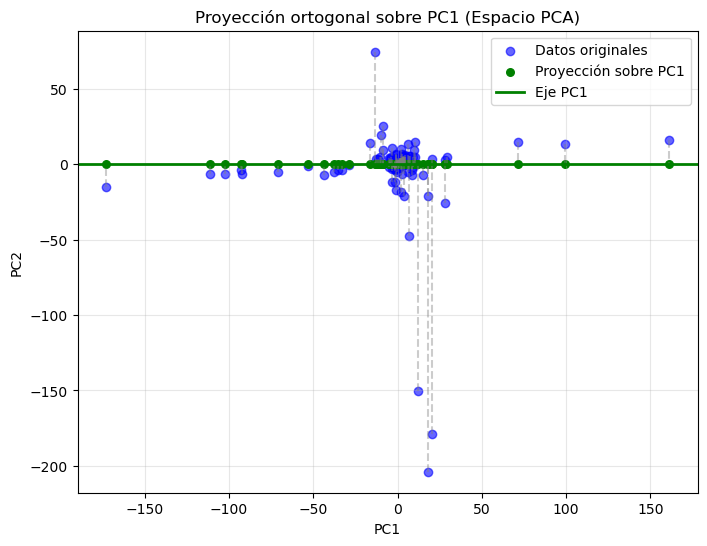

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_pca = pd.read_csv("dataset2_PCA_100.csv")

pc1 = df_pca["PC1"].values
pc2 = df_pca["PC2"].values

pc2_projected = np.zeros_like(pc2)

plt.figure(figsize=(8, 6))

plt.scatter(pc1, pc2, color="blue", alpha=0.6, label="Datos originales")

plt.scatter(pc1, pc2_projected, color="green", s=30, label="Proyección sobre PC1")

for x, y, y_proj in zip(pc1, pc2, pc2_projected):
    plt.plot([x, x], [y, y_proj], color="gray", linestyle="--", alpha=0.4)

plt.axhline(0, color="green", linewidth=2, label="Eje PC1")
plt.title("Proyección ortogonal sobre PC1 (Espacio PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


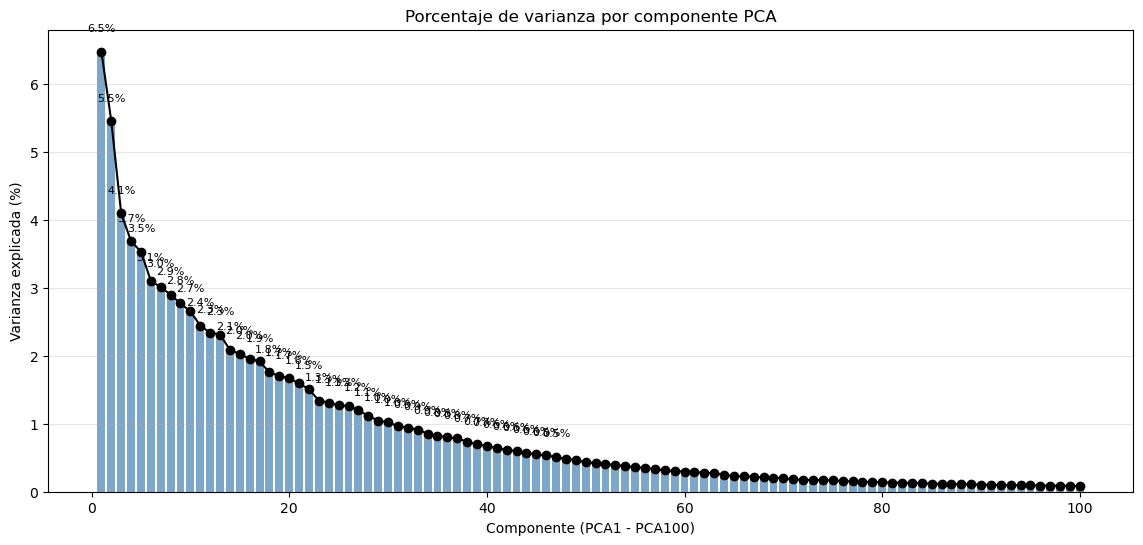

In [10]:
import numpy as np
import matplotlib.pyplot as plt

varianza_individual = pca_raw.explained_variance_ratio_ * 100

plt.figure(figsize=(14, 6))

plt.bar(range(1, len(varianza_individual) + 1), varianza_individual, alpha=0.7, color='steelblue')

plt.plot(range(1, len(varianza_individual) + 1), varianza_individual, color='black', marker='o')

for i, v in enumerate(varianza_individual):
    if v > 0.5: 
        plt.text(i + 1, v + 0.3, f"{v:.1f}%", ha='center', fontsize=8)

plt.title("Porcentaje de varianza por componente PCA")
plt.xlabel("Componente (PCA1 - PCA100)")
plt.ylabel("Varianza explicada (%)")
plt.grid(axis="y", alpha=0.3)
plt.show()
